## Seminar 6 - Neural networks for segmentation

In [45]:
! wget https://www.dropbox.com/s/o8loqc5ih8lp2m9/weights.pkl?dl=0

--2017-03-22 18:26:57--  https://www.dropbox.com/s/o8loqc5ih8lp2m9/weights.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/ilLm3ncIVSKJSXAaSK3phDo8g3SFQZK4ZMdelIyNYooXzctFghpk1GsmG57TA7ub/file [following]
--2017-03-22 18:26:59--  https://dl.dropboxusercontent.com/content_link/ilLm3ncIVSKJSXAaSK3phDo8g3SFQZK4ZMdelIyNYooXzctFghpk1GsmG57TA7ub/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132584649 (126M) [text/plain]
Saving to: ‘weights.pkl?dl=0’

weights.pkl?dl=0    100%[===================>] 126,44M  1015KB/s    in 2m 45s  

2017-03-22 18:29:45 (785 KB/s) - ‘weights.pkl?dl=0’ saved [132584649

In [ ]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
! unzip -q data.zip

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Задача на эту неделю: обучить сеть детектировать края клеток. 

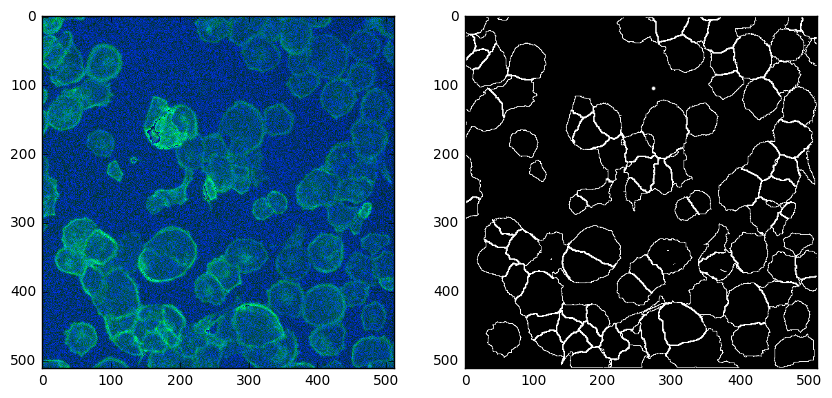

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

Самый естественный способ (но не самый эффективный) - свести задачу сегментации к задаче классификации отдельных патчей картинки. Очевидный плюс такого перехода - человечество уже придумало множество хороших архитектур для классификационных сеток (спасибо imagenet'y), в то время как с архитектурами для сегментационных сеток пока не все так однозначно.

In [3]:
def get_valid_patches(img_shape, patch_size, central_points):
    start = central_points - patch_size/2
    end = start + patch_size
    mask = np.logical_and(start >= 0, end < np.array(img_shape))
    mask = np.all(mask, axis=-1)
    return mask

def extract_patches(img, mask, n_pos=64, n_neg=64, patch_size=100):
    res = []
    labels = []
    pos = np.argwhere(mask > 0)
    accepted_patches_mask = get_valid_patches(np.array(img.shape[:2]), patch_size, pos)
    pos = pos[accepted_patches_mask]
    np.random.shuffle(pos)
    for i in range(n_pos):
        start = pos[i] - patch_size/2
        end = start + patch_size
        res.append(img[start[0]:end[0], start[1]:end[1]])
        labels.append(1)
        
    neg = np.argwhere(mask == 0)
    accepted_patches_mask = get_valid_patches(np.array(img.shape[:2]), patch_size, neg)
    neg = neg[accepted_patches_mask]
    np.random.shuffle(neg)
    for i in range(n_neg):
        start = neg[i] - patch_size/2
        end = start + patch_size
        res.append(img[start[0]:end[0], start[1]:end[1]])
        labels.append(0)
    return np.array(res), np.array(labels)

In [4]:
patches, labels = extract_patches(im, mask, 32,32)

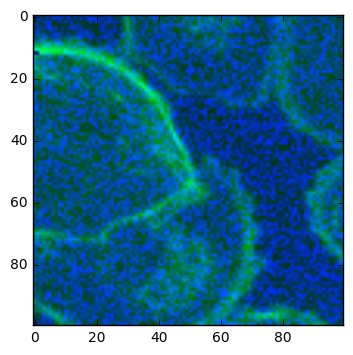

In [5]:
plt.imshow(patches[0])

In [6]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import BatchNormLayer, batch_norm
from lasagne.nonlinearities import softmax
import theano.tensor as T
import pickle
import lasagne.layers
import theano

In [7]:
with open('weights.pkl') as f:
    weights = pickle.load(f)

In [8]:
def build_network(weights):
    net = {}
    net['input'] = InputLayer((None, 3, 100, 100))
    net['conv1_1'] = batch_norm(ConvLayer(net['input'], num_filters=64, filter_size=3, pad=0, flip_filters=False,
                                         W=weights['conv1_1_w'], b=weights['conv1_1_b']), 
                                beta=weights['conv1_1_bn_beta'], gamma=weights['conv1_1_bn_gamma'], epsilon=1e-6)
    net['conv1_2'] = batch_norm(ConvLayer(net['conv1_1'], num_filters=64, filter_size=3, pad=0, flip_filters=False,
                                         W=weights['conv1_2_w'], b=weights['conv1_2_b']),
                                beta=weights['conv1_2_bn_beta'], gamma=weights['conv1_2_bn_gamma'], epsilon=1e-6)
    net['pool1'] = PoolLayer(net['conv1_2'], pool_size=2)

    net['conv2_1'] = batch_norm(ConvLayer(net['pool1'], num_filters=128, filter_size=3, pad=0, flip_filters=False,
                                         W=weights['conv2_1_w'], b=weights['conv2_1_b']), 
                                beta=weights['conv2_1_bn_beta'], gamma=weights['conv2_1_bn_gamma'], epsilon=1e-6)
    net['conv2_2'] = batch_norm(ConvLayer(net['conv2_1'], num_filters=128, filter_size=3, pad=0, flip_filters=False,
                                         W=weights['conv2_2_w'], b=weights['conv2_2_b']),
                                beta=weights['conv2_2_bn_beta'], gamma=weights['conv2_2_bn_gamma'], epsilon=1e-6)
    net['pool2'] = PoolLayer(net['conv2_2'], pool_size=2)
    
    net['conv3_1'] = batch_norm(ConvLayer(net['pool2'], num_filters=256, filter_size=3, pad=0, flip_filters=False,
                                         W=weights['conv3_1_w'], b=weights['conv3_1_b']), 
                                beta=weights['conv3_1_bn_beta'], gamma=weights['conv3_1_bn_gamma'], epsilon=1e-6)
    net['conv3_2'] = batch_norm(ConvLayer(net['conv3_1'], num_filters=256, filter_size=3, pad=0, flip_filters=False,
                                         W=weights['conv3_2_w'], b=weights['conv3_2_b']),
                                beta=weights['conv3_2_bn_beta'], gamma=weights['conv3_2_bn_gamma'], epsilon=1e-6)
    net['pool3'] = PoolLayer(net['conv3_2'], pool_size=2)
    
    net['fc1'] = batch_norm(DenseLayer(net['pool3'], num_units=512, 
                                       W=weights['fc1_w'], 
                                       b=weights['fc1_b']), 
                            beta=weights['fc1_bn_beta'], gamma=weights['fc1_bn_gamma'], epsilon=1e-6)
    net['fc2'] = DenseLayer(net['fc1'], num_units=2, W=weights['fc2_w'], b=weights['fc2_b'])
    net['prob'] = NonlinearityLayer(net['fc2'], softmax)
    return net



In [9]:
net = build_network(weights)

In [10]:
input_image = T.tensor4('input')
prob = lasagne.layers.get_output(net['prob'], input_image, batch_norm_use_averages=False)
get_probs = theano.function([input_image], prob)

In [11]:
def preproces(patches):
    patches = patches.astype(np.float32)
    patches = patches / 255 - 0.5
    patches = patches.transpose(0,3,1,2)
    return patches

In [12]:
predictions = get_probs(preproces(patches)).argmax(axis=-1)

In [13]:
print predictions
print (predictions == labels).mean()

[1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
0.828125


In [14]:
np.mean(predictions[:32] == 1), np.mean(predictions[32:] == 0)

(0.875, 0.78125)

_Вопрос_: это что ж, если мы хотим отсегментировать картинку, нам для каждого пикселя надо вытаскивать патч и их независимо через сетку прогонять?

_Ответ_: нет, можно модифицировать исходную сетку так, чтобы она принимала на вход картинку произвольного размера и возвращала для каждого пикселя вероятности классов. И это задача на сегодняшний семинар!

Что нам потребуется:
- избавиться от полносвязных слоев, превратив их в эквивалентные сверточные;
- избавиться от страйдов в пулинге, из-за которых размер картинки уменьшается.
- перейти от обычных сверток и пулингов к dilated-сверткам и dilated-пулингам.

In [17]:
from lasagne.layers import DilatedConv2DLayer as DilatedConvLayer

def dilated_pool2x2(incoming, dilation_rate):
    d,input_h,input_w = incoming.output_shape[-3:]
    #print "dilated pool", input_h, input_w
    # 1. padding 
    h_remainer = input_h % dilation_rate
    w_remainer = input_w % dilation_rate
    h_pad = 0 if h_remainer == 0 else dilation_rate - h_remainer
    w_pad = 0 if w_remainer == 0 else dilation_rate - w_remainer
    #print h_pad, w_pad
    incoming_padded = lasagne.layers.PadLayer(incoming, width=[(0, h_pad), (0, w_pad)], batch_ndim=2)
    h,w = incoming_padded.output_shape[-2:]
    assert h % dilation_rate == 0, "{} {}".format(h, dilation_rate)
    assert w % dilation_rate == 0, "{} {}".format(w, dilation_rate)
    
    # 2. reshape and transpose
    incoming_reshaped = lasagne.layers.ReshapeLayer(
        incoming_padded, ([0], [1], h/dilation_rate, dilation_rate, w/dilation_rate, dilation_rate))
    incoming_transposed = lasagne.layers.DimshuffleLayer(incoming_reshaped, 
                                (0, 1,3,5,2,4))
    incoming_reshaped = lasagne.layers.ReshapeLayer(incoming_transposed, ([0], -1, [4], [5]))
    
    # 3. max pool
    incoming_pooled = PoolLayer(incoming_reshaped, pool_size=2, stride=1)
    
    # 4. reshape
    pooled_reshaped = lasagne.layers.ReshapeLayer(incoming_pooled, ([0], d, dilation_rate, dilation_rate, [2], [3]))
    pooled_transposed = lasagne.layers.DimshuffleLayer(pooled_reshaped, (0, 1, 4, 2, 5, 3))
    pooled_reshaped = lasagne.layers.ReshapeLayer(pooled_transposed, ([0], [1], h - dilation_rate, w - dilation_rate))
    
    # 5. crop
    result = lasagne.layers.SliceLayer(pooled_reshaped, indices=slice(0, input_h - dilation_rate), axis=2) 
    result = lasagne.layers.SliceLayer(result, indices=slice(0, input_w - dilation_rate), axis=3) 
    return result

Обратите внимание на грабли, положенные в лазанье в реализации dilated convolution. Описание параметра W из документации:
> W : Theano shared variable, expression, numpy array or callable
>
>    Initial value, expression or initializer for the weights. These should be a 4D tensor with shape **(num_input_channels, num_filters, filter_rows, filter_columns)**. Note that the first two dimensions are swapped compared to a non-dilated convolution.


In [35]:
def build_network2(weights):
    net = {}
    dilation = 1
    net['input'] = InputLayer((None, 3, 200, 200))

    # TODO
    # you may copy-paste original function and fix it
    #net['conv1_1'] = 
    # ...
    #net['fc2'] = 

    #net['prob'] = NonlinearityLayer(net['fc2'], softmax)
    print "output_shape", net['fc2'].output_shape
    return net

In [36]:
net2 = build_network2(weights)

output_shape (None, 2, 101, 101)


In [37]:
input_image = T.tensor4('input')
fc2 = lasagne.layers.get_output(net2['fc2'], input_image, batch_norm_use_averages=False)


In [38]:
get_fc2 = theano.function([input_image], fc2)

Давайте посмотрим, что у нас получилось

In [39]:
%time predictions = get_fc2(preproces(im[None,:200, :200])).transpose(0,2,3,1)

CPU times: user 2min 9s, sys: 216 ms, total: 2min 9s
Wall time: 2min 9s


In [40]:
predictions.shape

(1, 101, 101, 2)

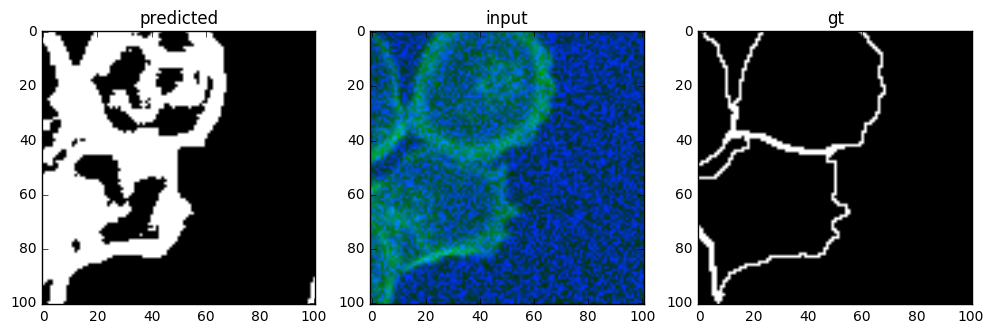

In [44]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(predictions[0].argmax(axis=-1), plt.cm.gray)
plt.title('predicted')
plt.subplot(1,3,2)
plt.imshow(im[49:200-50,49:200-50])
plt.title('input')
plt.subplot(1,3,3)
plt.imshow(mask[49:200-50,49:200-50], 'gray')
plt.title('gt')